# N-gram model - review

## required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from adjustText import adjust_text

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.inspection import PartialDependenceDisplay


C:\Users\rzp98\AppData\Local\Temp\ipykernel_5760\3596054760.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
df_review = pd.read_csv('review.csv')
df_product = pd.read_csv('product.csv')

## breif EDA

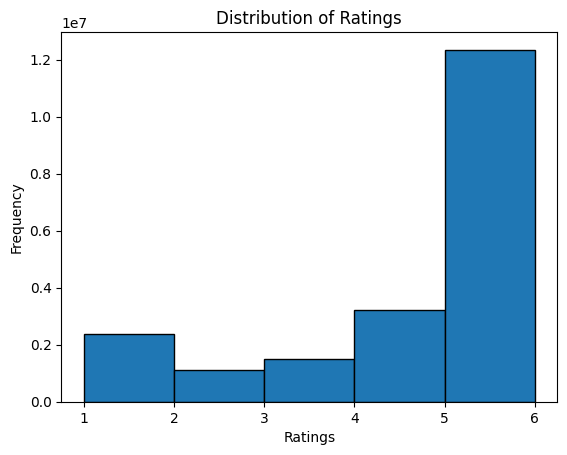

In [8]:
plt.hist(df_review['overall'], bins=range(1, 7), edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

In [9]:
# merge data set
df_review = df_review.merge(df_product[['asin', 'price']], on='asin', how='left')
df_review = df_review.merge(df_product[['asin', 'main_cat']], on='asin', how='left')
# add year column
df_review['reviewTime'] = pd.to_datetime(df_review['reviewTime'])
df_review['Year'] = df_review['reviewTime'].dt.year
del df_product

In [10]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20566364 entries, 0 to 20566363
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   overall     float64       
 1   verified    bool          
 2   reviewTime  datetime64[ns]
 3   asin        object        
 4   reviewText  object        
 5   vote        object        
 6   image       bool          
 7   price       float64       
 8   main_cat    object        
 9   Year        int32         
dtypes: bool(2), datetime64[ns](1), float64(2), int32(1), object(4)
memory usage: 1.2+ GB


In [11]:
df_review.value_counts("main_cat")

main_cat
Computers                                                                                                                                                                                         6732262
All Electronics                                                                                                                                                                                   3655780
Home Audio & Theater                                                                                                                                                                              3301869
Camera & Photo                                                                                                                                                                                    2502223
Cell Phones & Accessories                                                                                                                                                              

In [12]:
df_review['Year'].value_counts()

Year
2016    4405585
2015    4156845
2017    3129188
2014    2868469
2013    1855899
2018    1483404
2012     859667
2011     526073
2010     349181
2009     297368
2008     225597
2007     184953
2006      82854
2005      52511
2004      28983
2003      21053
2002      16787
2001      12893
2000       7977
1999       1074
1998          2
1997          1
Name: count, dtype: int64

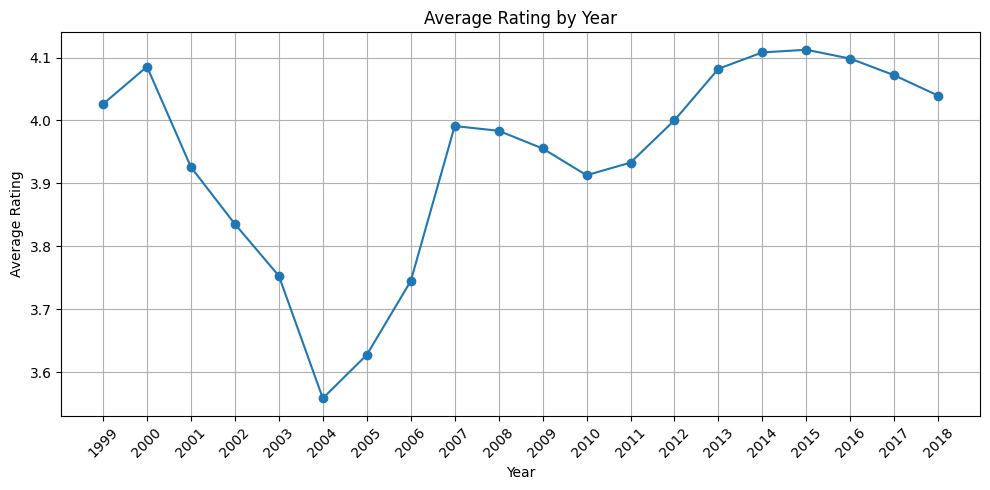

In [13]:
df_avg_rating = df_review.groupby('Year')['overall'].mean()
df_avg_rating.drop([1997, 1998], inplace=True)
plt.figure(figsize=(10, 5))  # Optional: Adjusts the size of the figure
plt.plot(df_avg_rating.index.astype(int), df_avg_rating, marker='o')  # Ensure index is integer
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating by Year')
plt.xticks(df_avg_rating.index.astype(int), rotation=45)  # Ensure x-ticks are integer years and rotate for better visibility

plt.grid(True)  
plt.tight_layout() 
plt.show()


# create subset for training

In [15]:
# select a subset and filter categoty for training
df_review.info()
df_review_filter = df_review.loc[df_review["main_cat"] == "Cell Phones & Accessories" ]
df_review_filter = df_review.sample(100000, random_state=0)
df_review_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20566364 entries, 0 to 20566363
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   overall     float64       
 1   verified    bool          
 2   reviewTime  datetime64[ns]
 3   asin        object        
 4   reviewText  object        
 5   vote        object        
 6   image       bool          
 7   price       float64       
 8   main_cat    object        
 9   Year        int32         
dtypes: bool(2), datetime64[ns](1), float64(2), int32(1), object(4)
memory usage: 1.2+ GB
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 11378681 to 16505067
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   overall     100000 non-null  float64       
 1   verified    100000 non-null  bool          
 2   reviewTime  100000 non-null  datetime64[ns]
 3   asin        100000 non-null  object        
 4

## Load normalisaed subset

In [2]:
# specify which df to put in df_review_filter
df_review_filter = pd.read_csv("df_camera_normalised.csv")
df_review_filter.dropna(subset=['reviewText'], inplace=True)
df_review_filter = df_review_filter.sample(df_review_filter.shape[0]//20, random_state=9)

C:\Users\rzp98\AppData\Local\Temp\ipykernel_28412\2903216142.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_review_filter = pd.read_csv("df_camera_normalised.csv")


In [135]:
df_review_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249575 entries, 1662620 to 1427636
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     249575 non-null  float64
 1   verified    249575 non-null  bool   
 2   reviewTime  249575 non-null  object 
 3   asin        249575 non-null  object 
 4   reviewText  249575 non-null  object 
 5   vote        45192 non-null   object 
 6   image       249575 non-null  bool   
 7   price       161162 non-null  float64
 8   main_cat    249575 non-null  object 
 9   Year        249575 non-null  int64  
dtypes: bool(2), float64(2), int64(1), object(5)
memory usage: 17.6+ MB


# LASSO:

### LASSO CoVe Normalised

In [145]:
# CoVe df_camera_normalised, 1/10, alpha = 0.01, Mean Squared Error: 1.3494160913389484, top features around 10

CoVe Lasso

In [3]:
alpha = 0.01
vectorizer = CountVectorizer(min_df=1)
lasso = Lasso(alpha=alpha)
pipeline = make_pipeline(vectorizer, lasso)

X_train, X_test, y_train, y_test = train_test_split(df_review_filter["reviewText"], df_review_filter["overall"], test_size=0.25, random_state=0)
pipeline.fit(X_train, y_train)
vectorizer_step = pipeline.named_steps['countvectorizer']

X_train_dfm = vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.319446365894085


In [19]:
i = np.argsort(lasso.coef_)[-5:]
top_five_features_name = np.array(vectorizer.get_feature_names_out())[i]   
top_five_features_name

array(['perfectly', 'excellent', 'love', 'perfect', 'great'], dtype=object)

In [28]:
bi = np.argsort(lasso.coef_)[:5]
bottom_five_features_name = np.array(vectorizer.get_feature_names_out())[bi]   
bottom_five_features_name

array(['return', 'waste', 'disappointed', 'break', 'bad'], dtype=object)

c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarn

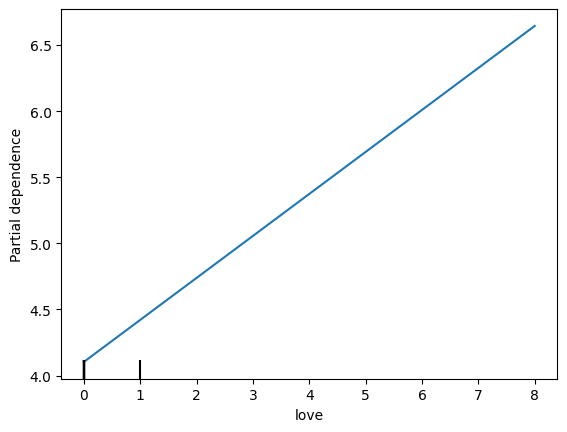

In [24]:
PartialDependenceDisplay.from_estimator(lasso, X_train_dfm_df, ["love"]) #PFP takes pd.df like object with column names 

c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\base.py:486: UserWarn

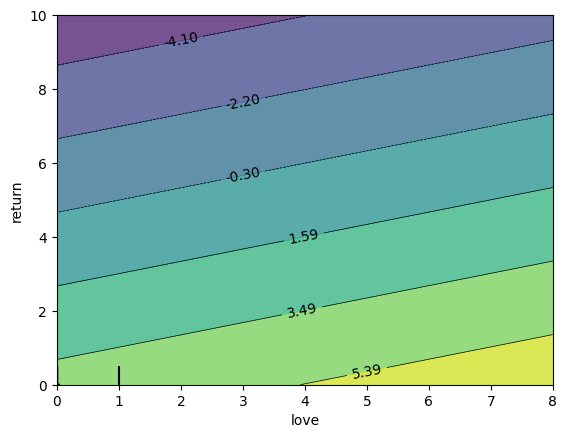

In [30]:

PartialDependenceDisplay.from_estimator(lasso, X_train_dfm_df, [("love","return")]) #PFP takes pd.df like object with column names 

CoVe LassoCV

In [ ]:
# Lasso CV
vectorizer = CountVectorizer(min_df=1)
lasso_cv = LassoCV(cv=5, random_state=1, alphas=[0.001, 0.01, 0.1, 1, 10, 100])
pipeline = make_pipeline(vectorizer, lasso_cv)

X_train, X_test, y_train, y_test = train_test_split(df_review_filter["reviewText"], df_review_filter["overall"], test_size=0.25, random_state=0)
pipeline.fit(X_train, y_train)
vectorizer_step = pipeline.named_steps['countvectorizer']

X_train_dfm = vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
best_alpha = pipeline.named_steps['lassocv'].alpha_
print(f'Best alpha: {best_alpha}')

### Bar Chart of Coefficients to Word Frequency Per Review (heat map)

In [ ]:
# coefficients = lasso_cv.coef_
coefficients = lasso.coef_
feature_names = vectorizer.get_feature_names_out()
features_coefficients = zip(feature_names, coefficients)
filtered_features_coefficients = filter(lambda x: x[1] != 0, features_coefficients)
sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
sorted_features_lasso_CoVe_NoN, sorted_coefficients_lasso_CoVe_NoN = zip(*sorted_features_coefficients)

top_pos_features_lasso_CoVe_NoN = []
top_pos_coef_lasso_CoVe_NoN = []
top_pos_features_feq_lasso_CoVe_NoN = []

top_neg_features_lasso_CoVe_NoN = []
top_neg_coef_lasso_CoVe_NoN = []
top_neg_features_feq_lasso_CoVe_NoN = []

for index, coef in enumerate(sorted_coefficients_lasso_CoVe_NoN):
    if coef > 0:
        top_pos_features_lasso_CoVe_NoN.append(sorted_features_lasso_CoVe_NoN[index])
        top_pos_features_feq_lasso_CoVe_NoN.append(sum(X_train_dfm_df[sorted_features_lasso_CoVe_NoN[index]]))
        top_pos_coef_lasso_CoVe_NoN.append(coef)
    else:
        top_neg_features_lasso_CoVe_NoN.append(sorted_features_lasso_CoVe_NoN[index])
        top_neg_features_feq_lasso_CoVe_NoN.append(sum(X_train_dfm_df[sorted_features_lasso_CoVe_NoN[index]]))
        top_neg_coef_lasso_CoVe_NoN.append(coef)



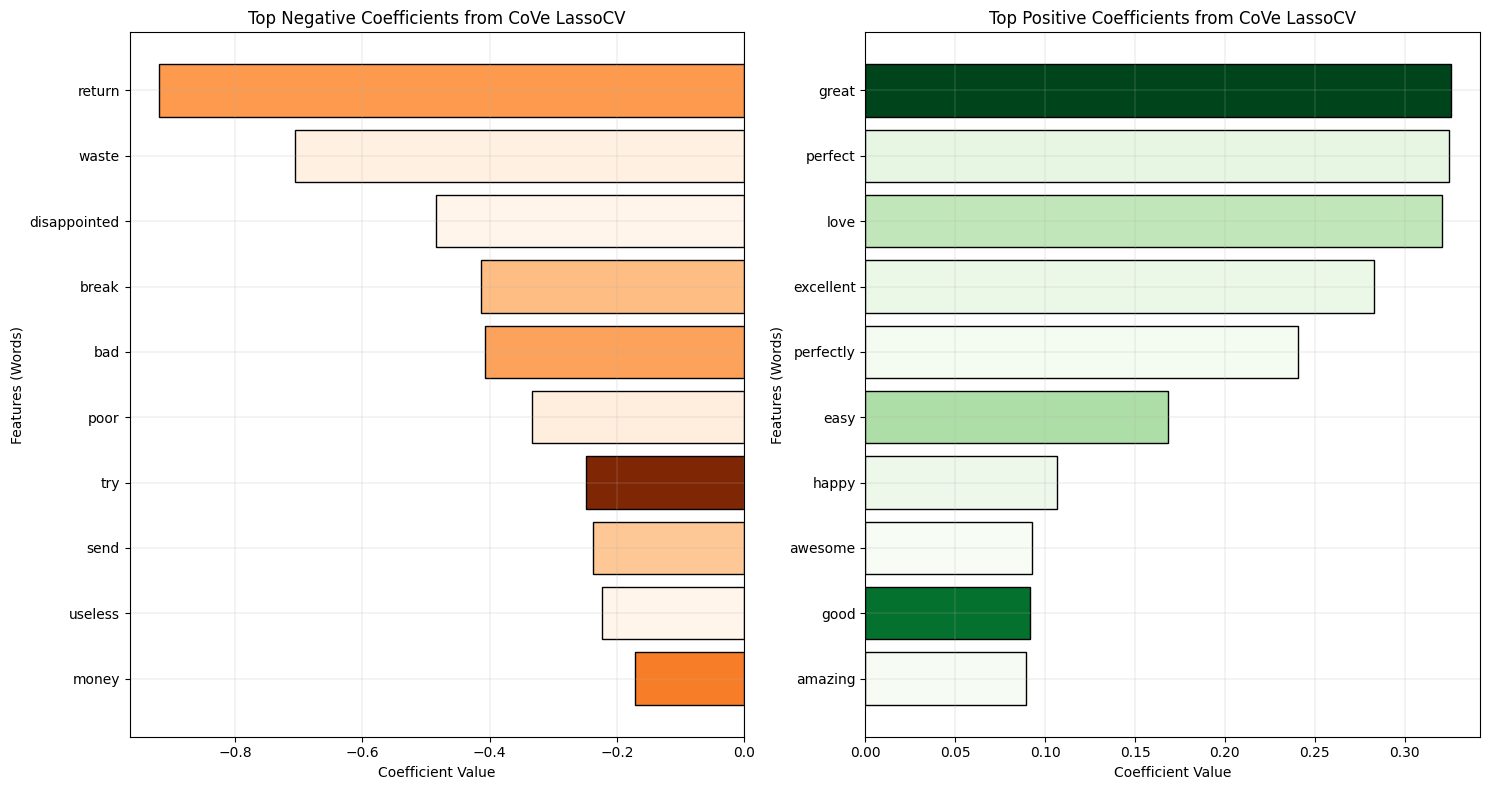

In [ ]:
show = 10

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

norm_neg = mcolors.Normalize(vmin=min(top_neg_features_feq_lasso_CoVe_NoN[:show]), 
                             vmax=max(top_neg_features_feq_lasso_CoVe_NoN[:show]))
norm_pos = mcolors.Normalize(vmin=min(top_pos_features_feq_lasso_CoVe_NoN[:show]), 
                             vmax=max(top_pos_features_feq_lasso_CoVe_NoN[:show]))

# Creating a color map: 'Blues' 'Greens' 'Reds' 'Purples' 'Oranges' 'Greys''Spectral''coolwarm''PiYG''PRGn''RdBu''RdYlBu''RdYlGn''YlGnBu'

cmap = plt.cm.Oranges
for i in range(show):
    color = cmap(norm_neg(top_neg_features_feq_lasso_CoVe_NoN[i]))
    ax1.barh(top_neg_features_lasso_CoVe_NoN[i], top_neg_coef_lasso_CoVe_NoN[i], color=color, edgecolor='black', linewidth=1)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Features (Words)')
ax1.set_title('Top Negative Coefficients from CoVe LassoCV')
ax1.invert_yaxis()
ax1.grid(True, which='both', linestyle='-', linewidth=0.2)

cmap = plt.cm.Greens
for i in range(show):
    color = cmap(norm_pos(top_pos_features_feq_lasso_CoVe_NoN[i]))
    ax2.barh(top_pos_features_lasso_CoVe_NoN[i], top_pos_coef_lasso_CoVe_NoN[i], color=color,edgecolor='black', linewidth=1)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Features (Words)')
ax2.set_title('Top Positive Coefficients from CoVe LassoCV')
ax2.invert_yaxis()
ax2.grid(True, which='both', linestyle='-', linewidth=0.2)

plt.tight_layout()
plt.show()


### Scatter plot of Coefficients to Word Frequency Per Review

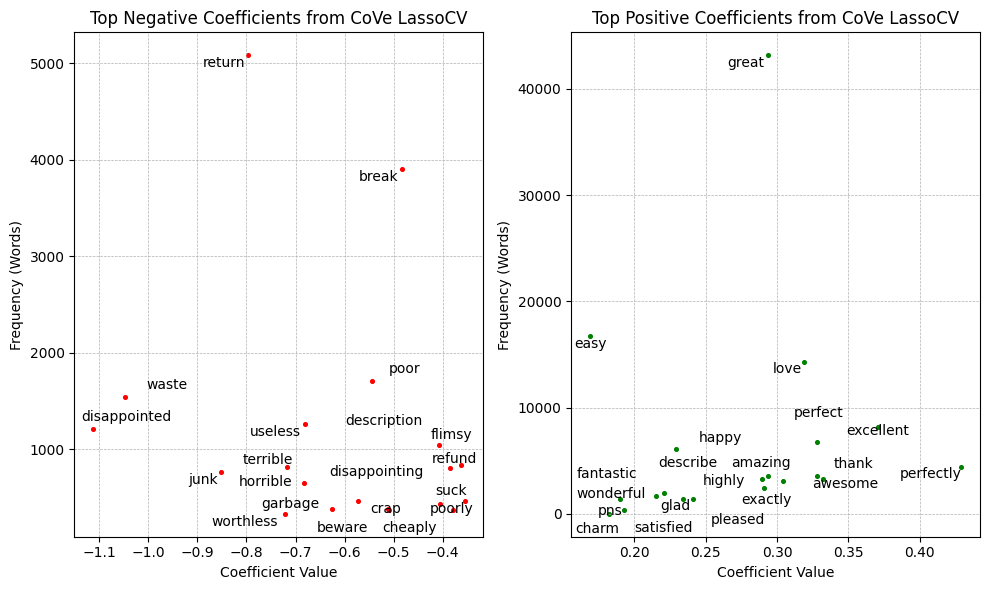

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

show = 20

ax1.scatter(top_neg_coef_lasso_CoVe_NoN[:show], top_neg_features_feq_lasso_CoVe_NoN[:show],s= 7, color='red')
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency (Words)')
ax1.set_title('Top Negative Coefficients from CoVe LassoCV')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

texts1 = []
for i, label in enumerate(top_neg_features_lasso_CoVe_NoN[:show]):
    texts1.append(ax1.text(top_neg_coef_lasso_CoVe_NoN[i], top_neg_features_feq_lasso_CoVe_NoN[i], label))
adjust_text(texts1, ax=ax1)

ax2.scatter(top_pos_coef_lasso_CoVe_NoN[:show], top_pos_features_feq_lasso_CoVe_NoN[:show], s= 7, color='green')
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency (Words)')
ax2.set_title('Top Positive Coefficients from CoVe LassoCV')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

texts2 = []
for i, label in enumerate(top_pos_features_lasso_CoVe_NoN[:show]):
    texts2.append(ax2.text(top_pos_coef_lasso_CoVe_NoN[i], top_pos_features_feq_lasso_CoVe_NoN[i], label))
adjust_text(texts2, ax=ax2)

plt.tight_layout()
plt.show()


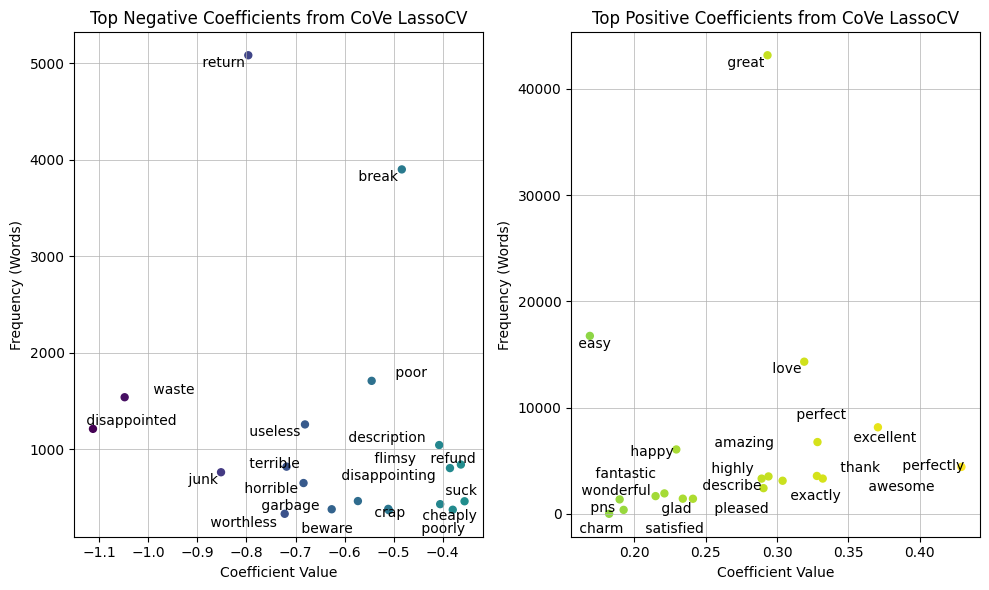

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from adjustText import adjust_text

# Assuming top_neg_coef_lasso_CoVe_NoN, top_neg_features_feq_lasso_CoVe_NoN, top_pos_coef_lasso_CoVe_NoN, and top_pos_features_feq_lasso_CoVe_NoN are defined

# Creating a color map based on coefficient values
cmap = plt.cm.viridis

# Normalize coefficient values for color mapping
norm = mcolors.Normalize(vmin=min(min(top_neg_coef_lasso_CoVe_NoN[:show]), 
                                  min(top_pos_coef_lasso_CoVe_NoN[:show])), 
                         vmax=max(max(top_neg_coef_lasso_CoVe_NoN[:show]), 
                                  max(top_pos_coef_lasso_CoVe_NoN[:show])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Store text objects for adjustText
texts1 = []
texts2 = []

# Negative Coefficients Scatter Plot
scatter = ax1.scatter(top_neg_coef_lasso_CoVe_NoN[:show], top_neg_features_feq_lasso_CoVe_NoN[:show],
                      c=top_neg_coef_lasso_CoVe_NoN[:show], cmap=cmap, norm=norm, s = 25)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency (Words)')
ax1.set_title('Top Negative Coefficients from CoVe LassoCV')
ax1.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_neg_features_lasso_CoVe_NoN[:show]):
    texts1.append(ax1.text(top_neg_coef_lasso_CoVe_NoN[i], top_neg_features_feq_lasso_CoVe_NoN[i], ' '+label,
             verticalalignment='center', fontsize=10))

# Positive Coefficients Scatter Plot
scatter = ax2.scatter(top_pos_coef_lasso_CoVe_NoN[:show], top_pos_features_feq_lasso_CoVe_NoN[:show],
                      c=top_pos_coef_lasso_CoVe_NoN[:show], cmap=cmap, norm=norm, s = 25)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency (Words)')
ax2.set_title('Top Positive Coefficients from CoVe LassoCV')
ax2.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_pos_features_lasso_CoVe_NoN[:show]):
    texts2.append(ax2.text(top_pos_coef_lasso_CoVe_NoN[i], top_pos_features_feq_lasso_CoVe_NoN[i], ' '+label,
             verticalalignment='center', fontsize=10))

# Apply adjust_text to improve label placement
adjust_text(texts1, ax=ax1, )
adjust_text(texts2, ax=ax2,)

plt.tight_layout()
plt.show()


### Intertemporal review to ratings

In [ ]:
df_review_filter["Year"].value_counts()

Year
2016    21263
2015    20377
2017    15192
2014    13851
2013     9057
2018     7273
2012     4146
2011     2566
2010     1713
2009     1425
2008     1126
2007      894
2006      407
2005      263
2004      148
2003      102
2002       85
2001       67
2000       39
1999        6
Name: count, dtype: int64

Best alpha: 0.01 for 2000
year 2000 lasso fitting complete
Best alpha: 0.01 for 2001
year 2001 lasso fitting complete


/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33438144062850833, tolerance: 0.006
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0692933527715221, tolerance: 0.004890909090909091
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5178412622911193, tolerance: 0.010945454545454552
  model = cd_fast.sparse_enet_coordinate_descent(


Best alpha: 0.01 for 2002
year 2002 lasso fitting complete


/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025825061019758344, tolerance: 0.009162000000000002
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6322359378341731, tolerance: 0.0132
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21578528351727666, tolerance: 0.022411000000000007
  model = cd_fast.sparse_enet_coordinate_descen

Best alpha: 0.01 for 2003
year 2003 lasso fitting complete


/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19304916467847466, tolerance: 0.01357808219178082
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05159944724534782, tolerance: 0.030302054794520552
  model = cd_fast.sparse_enet_coordinate_descent(


Best alpha: 0.01 for 2004
year 2004 lasso fitting complete


/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1301407067985707, tolerance: 0.031430769230769234
  model = cd_fast.sparse_enet_coordinate_descent(


Best alpha: 0.01 for 2005
year 2005 lasso fitting complete


/Users/ran/Desktop/temp_tmef/temp_tmef_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15683529667396812, tolerance: 0.03955223880597019
  model = cd_fast.sparse_enet_coordinate_descent(


Best alpha: 0.01 for 2006
year 2006 lasso fitting complete
Best alpha: 0.01 for 2007
year 2007 lasso fitting complete
Best alpha: 0.01 for 2008
year 2008 lasso fitting complete
Best alpha: 0.01 for 2009
year 2009 lasso fitting complete
Best alpha: 0.01 for 2010
year 2010 lasso fitting complete
Best alpha: 0.01 for 2011
year 2011 lasso fitting complete
Best alpha: 0.01 for 2012
year 2012 lasso fitting complete
Best alpha: 0.01 for 2013
year 2013 lasso fitting complete
Best alpha: 0.01 for 2014
year 2014 lasso fitting complete
Best alpha: 0.01 for 2015
year 2015 lasso fitting complete
Best alpha: 0.01 for 2016
year 2016 lasso fitting complete


IndexError: index 16 is out of bounds for axis 0 with size 16

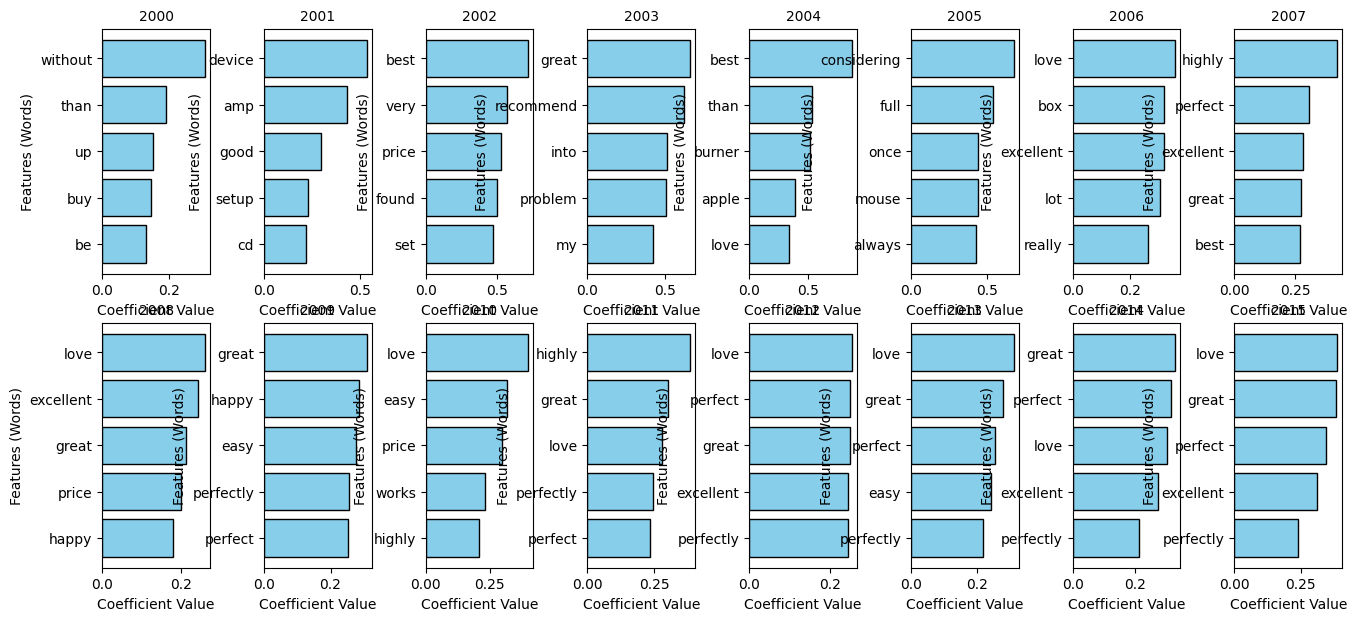

In [ ]:
show = 5 # how many top coefficient to show

fig, axes = plt.subplots(2, 8, figsize=(16, 7))  
plt.subplots_adjust(wspace=0.5, hspace=0.2)
axes = axes.ravel() 

for i, year in enumerate(range(2000, 2017)):
    df_year = df_review_filter[df_review_filter["Year"] == year]

    if not df_year.empty:
    
        X_train, X_test, y_train, y_test = train_test_split(df_year["reviewText"], df_year["overall"], test_size=0.01, random_state=0)

        # Create the pipeline and fit the model
        vectorizer = CountVectorizer(min_df=1)
        lasso_cv = LassoCV(cv=2, random_state=0, alphas=[0.01]) # 0.001, 0.01, 0.1, 1, 100
        pipeline = make_pipeline(vectorizer, lasso_cv)
        pipeline.fit(X_train, y_train)
        best_alpha = pipeline.named_steps['lassocv'].alpha_
        print(f'Best alpha: {best_alpha} for {year}')  


        # Get the coefficients and feature names
        coefficients = pipeline.named_steps['lassocv'].coef_
        feature_names = pipeline.named_steps['countvectorizer'].get_feature_names_out()
        features_coefficients = zip(feature_names, coefficients)
        filtered_features_coefficients = filter(lambda x: x[1] > 0, features_coefficients)  # Filter only positive coefficients
        sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: x[1], reverse=True)
        print(f"year {year} lasso fitting complete")
        # Get the top positive features and their coefficients
        top_features, top_coefficients = zip(*sorted_features_coefficients[:show])

        # Plotting
        ax = axes[i]
        ax.barh(top_features, top_coefficients, color='skyblue', edgecolor='black', linewidth=1)
        ax.set_title(f'{year}',fontsize=10)
        ax.invert_yaxis()  # To display the highest coefficient at the top
        ax.set_xlabel('Coefficient Value')
        ax.set_ylabel('Features (Words)')
    else:
        axes[i].axis('off')  # Hide axes if there is no data for the year

plt.tight_layout()
plt.show()


ValueError: Cannot have number of splits n_splits=2 greater than the number of samples: n_samples=1.

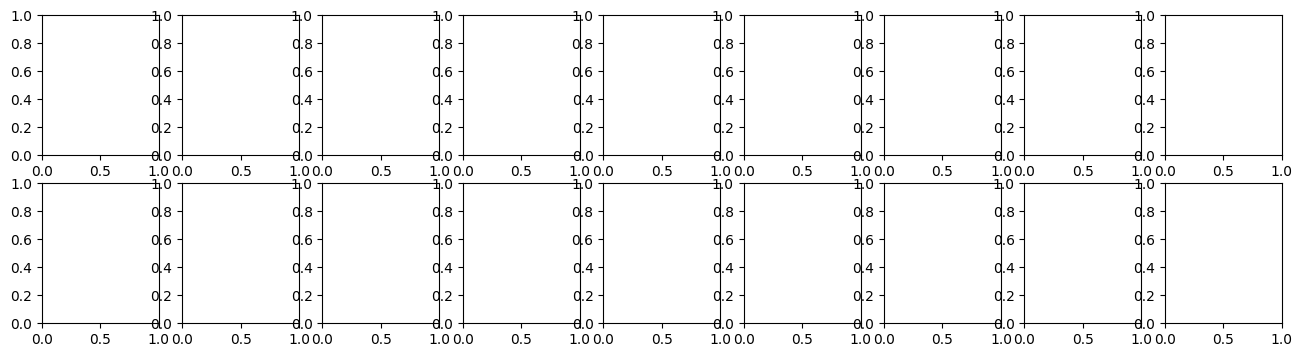

In [ ]:
show = 5 # how many top coefficient to show

fig, axes = plt.subplots(2, 9, figsize=(16, 4))  
axes = axes.ravel() 

for i, year in enumerate(range(2001, 2019)):
    df_year = df_review_filter[df_review_filter["Year"] == year]

    if not df_year.empty:
    
        X_train, X_test, y_train, y_test = train_test_split(df_year["reviewText"], df_year["overall"], test_size=0.25, random_state=0)

        # Create the pipeline and fit the model
        vectorizer = CountVectorizer(min_df=1)
        lasso_cv = LassoCV(cv=2, random_state=1, alphas=[0.001, 0.01, 0.1, 1, 10, 100])
        pipeline = make_pipeline(vectorizer, lasso_cv)
        pipeline.fit(X_train, y_train)

        # Get the coefficients and feature names
        coefficients = pipeline.named_steps['lassocv'].coef_
        feature_names = pipeline.named_steps['countvectorizer'].get_feature_names_out()
        features_coefficients = zip(feature_names, coefficients)
        filtered_features_coefficients = filter(lambda x: x[1] > 0, features_coefficients)  # Filter only positive coefficients
        sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: x[1], reverse=True)

        # Get the top positive features and their coefficients
        top_features, top_coefficients = zip(*sorted_features_coefficients[:show])

        # Plotting
        ax = axes[i]
        ax.barh(top_features, top_coefficients, color='skyblue', edgecolor='black', linewidth=1)
        ax.set_title(f'Top Positive Coefficients from CoVe LassoCV {year}')
        ax.invert_yaxis()  # To display the highest coefficient at the top
        ax.set_xlabel('Coefficient Value')
        ax.set_ylabel('Features (Words)')
    else:
        axes[i].axis('off')  # Hide axes if there is no data for the year

plt.tight_layout()
plt.show()


## TfidfVectorizer 

Tifdif Lasso

In [ ]:
alpha = 0.01
vectorizer = TfidfVectorizer(min_df=0.05, ngram_range=(1, 2))
lasso = Lasso(alpha=alpha)
pipeline = make_pipeline(vectorizer, lasso)

X_train, X_test, y_train, y_test = train_test_split(df_review_filter["reviewText"], df_review_filter["overall"], test_size=0.25, random_state=0)
pipeline.fit(X_train, y_train)
vectorizer_step = pipeline.named_steps['tfidfvectorizer']

X_train_dfm = vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.5364182280819236


Tifdif Lasso CV

### Bar Chart of Coefficients to Word Frequency Per Review (heat map)

In [ ]:
# coefficients = lasso_cv.coef_
coefficients = lasso.coef_
feature_names = vectorizer.get_feature_names_out()
features_coefficients = zip(feature_names, coefficients)
filtered_features_coefficients = filter(lambda x: x[1] != 0, features_coefficients)
sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
sorted_features_lasso_Tif_NoN, sorted_coefficients_lasso_Tif_NoN = zip(*sorted_features_coefficients)

top_pos_features_lasso_Tif_NoN = []
top_pos_coef_lasso_Tif_NoN = []
top_pos_features_feq_lasso_Tif_NoN = []

top_neg_features_lasso_Tif_NoN = []
top_neg_coef_lasso_Tif_NoN = []
top_neg_features_feq_lasso_Tif_NoN = []

for index, coef in enumerate(sorted_coefficients_lasso_Tif_NoN):
    if coef > 0:
        top_pos_features_lasso_Tif_NoN.append(sorted_features_lasso_Tif_NoN[index])
        top_pos_features_feq_lasso_Tif_NoN.append(sum(X_train_dfm_df[sorted_features_lasso_Tif_NoN[index]]))
        top_pos_coef_lasso_Tif_NoN.append(coef)
    else:
        top_neg_features_lasso_Tif_NoN.append(sorted_features_lasso_Tif_NoN[index])
        top_neg_features_feq_lasso_Tif_NoN.append(sum(X_train_dfm_df[sorted_features_lasso_Tif_NoN[index]]))
        top_neg_coef_lasso_Tif_NoN.append(coef)



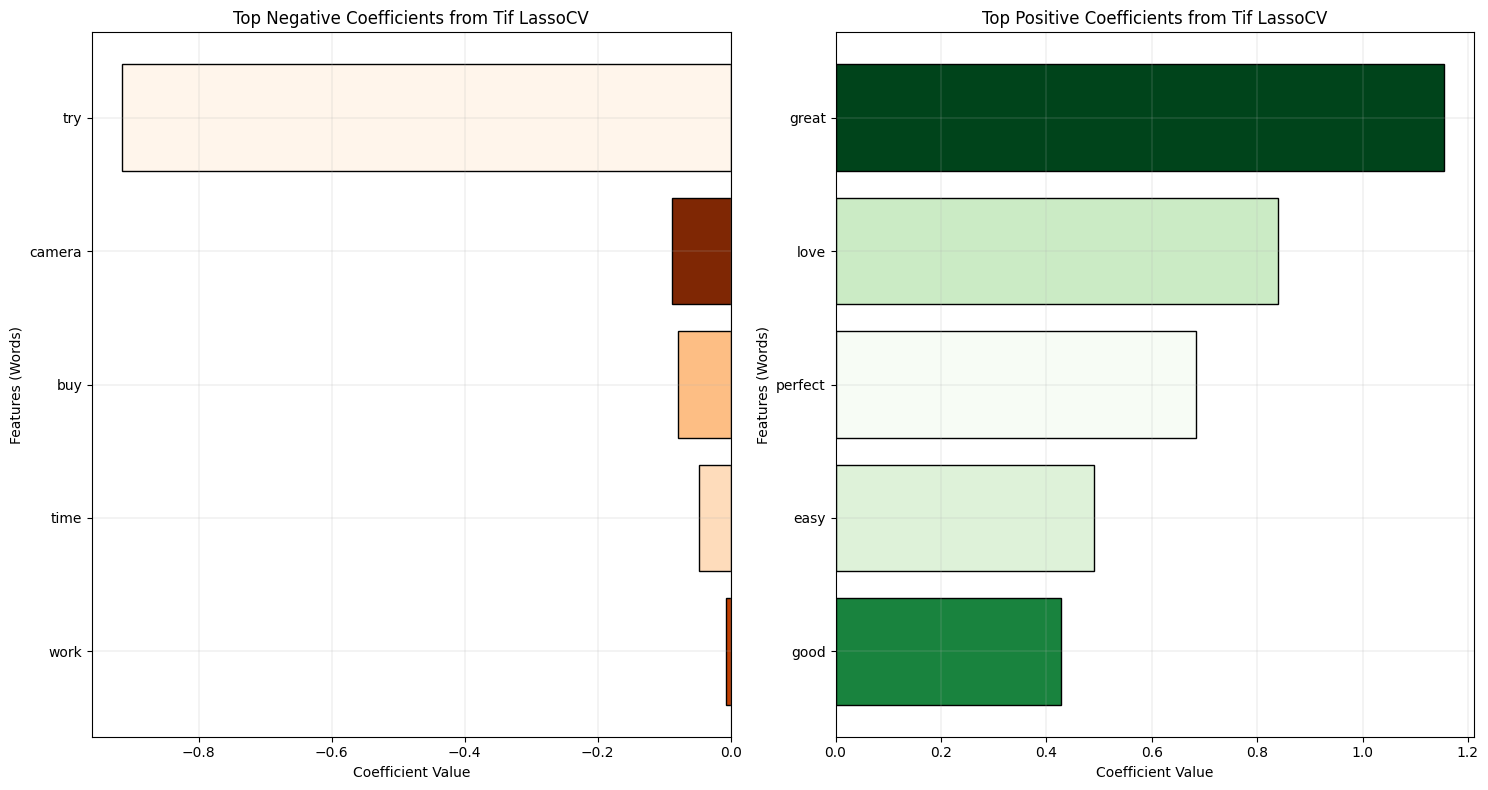

In [ ]:
show = 5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

norm_neg = mcolors.Normalize(vmin=min(top_neg_features_feq_lasso_Tif_NoN[:show]), 
                             vmax=max(top_neg_features_feq_lasso_Tif_NoN[:show]))
norm_pos = mcolors.Normalize(vmin=min(top_pos_features_feq_lasso_Tif_NoN[:show]), 
                             vmax=max(top_pos_features_feq_lasso_Tif_NoN[:show]))

# Creating a color map: 'Blues' 'Greens' 'Reds' 'Purples' 'Oranges' 'Greys''Spectral''coolwarm''PiYG''PRGn''RdBu''RdYlBu''RdYlGn''YlGnBu'

cmap = plt.cm.Oranges
for i in range(show):
    color = cmap(norm_neg(top_neg_features_feq_lasso_Tif_NoN[i]))
    ax1.barh(top_neg_features_lasso_Tif_NoN[i], top_neg_coef_lasso_Tif_NoN[i], color=color, edgecolor='black', linewidth=1)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Features (Words)')
ax1.set_title('Top Negative Coefficients from Tif LassoCV')
ax1.invert_yaxis()
ax1.grid(True, which='both', linestyle='-', linewidth=0.2)

cmap = plt.cm.Greens
for i in range(show):
    color = cmap(norm_pos(top_pos_features_feq_lasso_Tif_NoN[i]))
    ax2.barh(top_pos_features_lasso_Tif_NoN[i], top_pos_coef_lasso_Tif_NoN[i], color=color,edgecolor='black', linewidth=1)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Features (Words)')
ax2.set_title('Top Positive Coefficients from Tif LassoCV')
ax2.invert_yaxis()
ax2.grid(True, which='both', linestyle='-', linewidth=0.2)

plt.tight_layout()
plt.show()


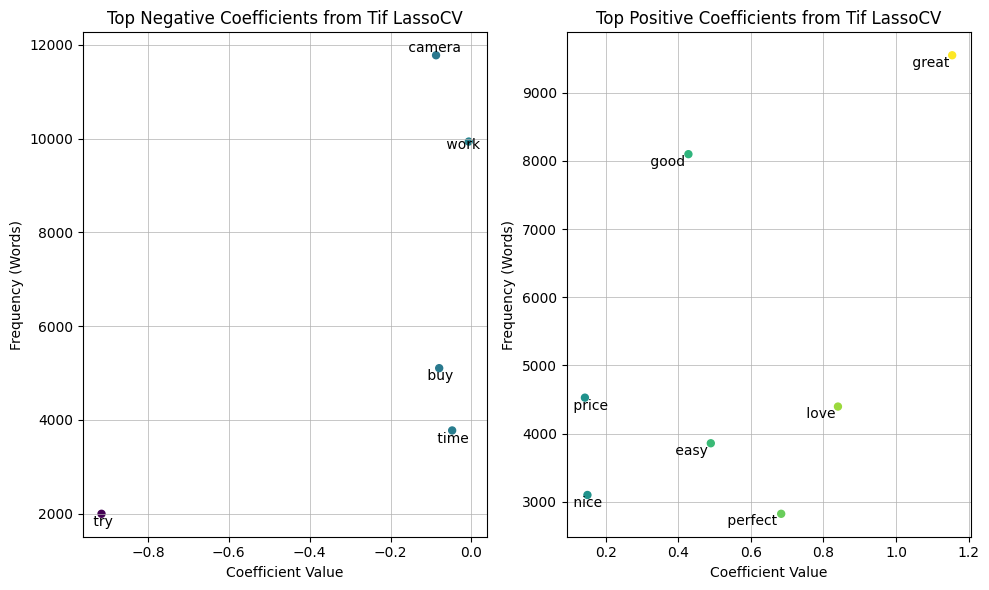

In [ ]:

cmap = plt.cm.viridis

# Normalize coefficient values for color mapping
norm = mcolors.Normalize(vmin=min(min(top_neg_coef_lasso_Tif_NoN[:show]), 
                                  min(top_pos_coef_lasso_Tif_NoN[:show])), 
                         vmax=max(max(top_neg_coef_lasso_Tif_NoN[:show]), 
                                  max(top_pos_coef_lasso_Tif_NoN[:show])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Store text objects for adjustText
texts1 = []
texts2 = []

# Negative Coefficients Scatter Plot
scatter = ax1.scatter(top_neg_coef_lasso_Tif_NoN[:show], top_neg_features_feq_lasso_Tif_NoN[:show],
                      c=top_neg_coef_lasso_Tif_NoN[:show], cmap=cmap, norm=norm, s = 25)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency (Words)')
ax1.set_title('Top Negative Coefficients from Tif LassoCV')
ax1.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_neg_features_lasso_Tif_NoN[:show]):
    texts1.append(ax1.text(top_neg_coef_lasso_Tif_NoN[i], top_neg_features_feq_lasso_Tif_NoN[i], ' '+label,
             verticalalignment='center', fontsize=10))

# Positive Coefficients Scatter Plot
scatter = ax2.scatter(top_pos_coef_lasso_Tif_NoN[:show], top_pos_features_feq_lasso_Tif_NoN[:show],
                      c=top_pos_coef_lasso_Tif_NoN[:show], cmap=cmap, norm=norm, s = 25)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency (Words)')
ax2.set_title('Top Positive Coefficients from Tif LassoCV')
ax2.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_pos_features_lasso_Tif_NoN[:show]):
    texts2.append(ax2.text(top_pos_coef_lasso_Tif_NoN[i], top_pos_features_feq_lasso_Tif_NoN[i], ' '+label,
             verticalalignment='center', fontsize=10))

# Apply adjust_text to improve label placement
adjust_text(texts1, ax=ax1, )
adjust_text(texts2, ax=ax2,)

plt.tight_layout()
plt.show()


# random stuff

catboost

In [71]:
# catboost, ngram 1,2, traning time = 25 min, mse = 0.7, only one twogram showed in top 10 importance which is "stop_work"

In [6]:
from catboost import CatBoostRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming df_review_filter is your DataFrame with reviewText and overall rating

# Initialize the vectorizer
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1))

# Transform text data into TF-IDF
X = vectorizer.fit_transform(df_review_filter["reviewText"])
y = df_review_filter["overall"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Initialize and train the CatBoost regressor
catboost_regressor = CatBoostRegressor(verbose=False,
                                       task_type="GPU",
                                       devices='0:1') 
catboost_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred = catboost_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.8755036265392505


In [ ]:
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder

# Convert ratings into two categories
y_class = (df_review_filter["overall"] > 3).astype(int)  # 1 for high, 0 for low

# Split the dataset
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.25, random_state=0)

# Initialize and train the CatBoost classifier
catboost_classifier = CatBoostClassifier(verbose=False) # Turn off verbose to reduce log noise
catboost_classifier.fit(X_train, y_train_class)

# Predict and evaluate
y_pred_class = catboost_classifier.predict(X_test)
accuracy = (y_pred_class == y_test_class).mean()
print(f'Accuracy: {accuracy}')


Accuracy: 0.7968073853255121


In [10]:
i = np.argsort(catboost_regressor.get_feature_importance())[-5:]
top_five_features_name = np.array(vectorizer.get_feature_names_out())[i]   
top_five_features_name

array(['break', 'love', 'waste', 'great', 'return'], dtype=object)

In [11]:
i

array([ 3912, 18319, 35126, 13760, 26646], dtype=int64)

In [15]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features_i = 3912
feature_names = vectorizer.get_feature_names_out()

PartialDependenceDisplay.from_estimator(catboost_regressor, X_train.todense(), [features_i])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

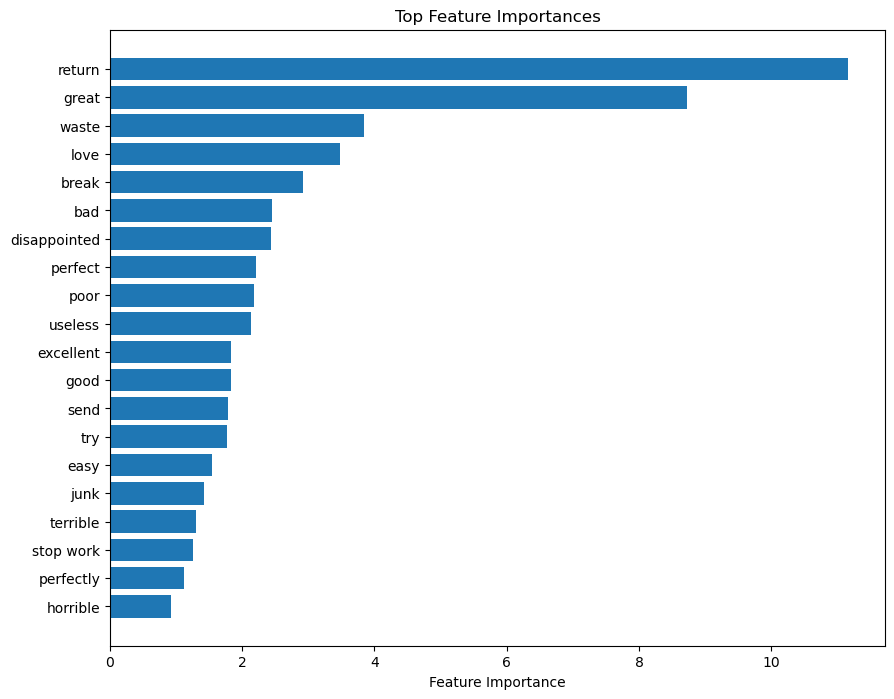

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model, vectorizer, n_top_features=20):
    # Get feature importances and feature names
    feature_importances = model.get_feature_importance()
    feature_names = vectorizer.get_feature_names_out()

    # Sort features by importance
    indices = np.argsort(feature_importances)[-n_top_features:]
    
    # Prepare data for plotting
    top_features = np.array(feature_names)[indices]
    top_importances = feature_importances[indices]

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.barh(range(n_top_features), top_importances, align='center')
    plt.yticks(range(n_top_features), top_features)
    plt.xlabel('Feature Importance')
    plt.title('Top Feature Importances')
    plt.show()

# Assuming catboost_regressor and vectorizer are already defined and trained as shown above
plot_feature_importances(catboost_regressor, vectorizer)



review image and votes

In [160]:
df_review_merged = pd.read_csv('df_review_merged.csv')
df_review_merged.info()

C:\Users\rzp98\AppData\Local\Temp\ipykernel_5760\3956128325.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_review_merged = pd.read_csv('df_review_merged.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20566364 entries, 0 to 20566363
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   verified    bool   
 2   reviewTime  object 
 3   asin        object 
 4   reviewText  object 
 5   vote        object 
 6   image       bool   
 7   price       float64
 8   main_cat    object 
 9   Year        int64  
dtypes: bool(2), float64(2), int64(1), object(5)
memory usage: 1.3+ GB


In [ ]:

df_review_merged['vote'] = df_review_merged['vote'].str.replace(',', '').astype(float)


In [215]:
df_review_merged['vote'].isna().sum()

0

In [214]:
df_review_merged = df_review_merged.dropna(subset=['vote'])

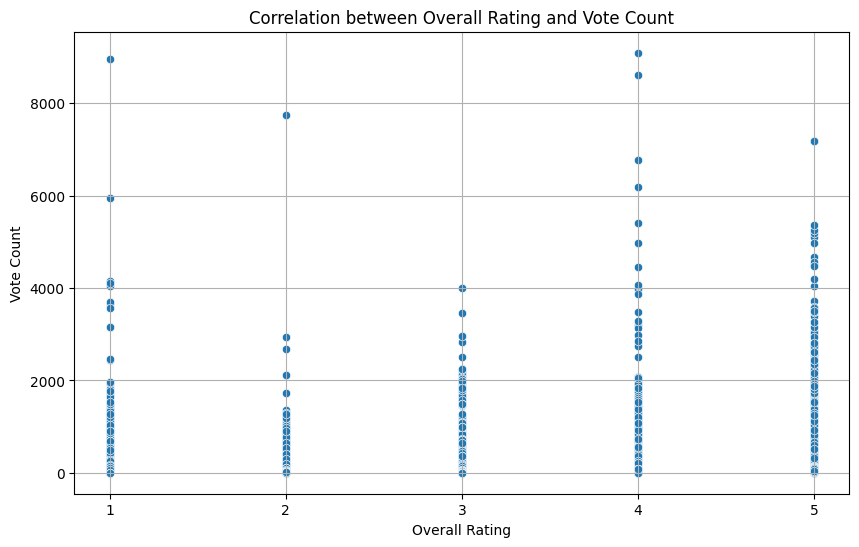

0.019782066960203546

In [216]:
correlation = df_review_merged['overall'].corr(df_review_merged['vote'])

# Visualize the correlation
plt.figure(figsize=(10, 6))
plt.xticks([1, 2, 3, 4, 5])
sns.scatterplot(x='overall', y='vote', data=df_review_merged)
plt.title('Correlation between Overall Rating and Vote Count')
plt.xlabel('Overall Rating')
plt.ylabel('Vote Count')
plt.grid(True)
plt.show()

correlation

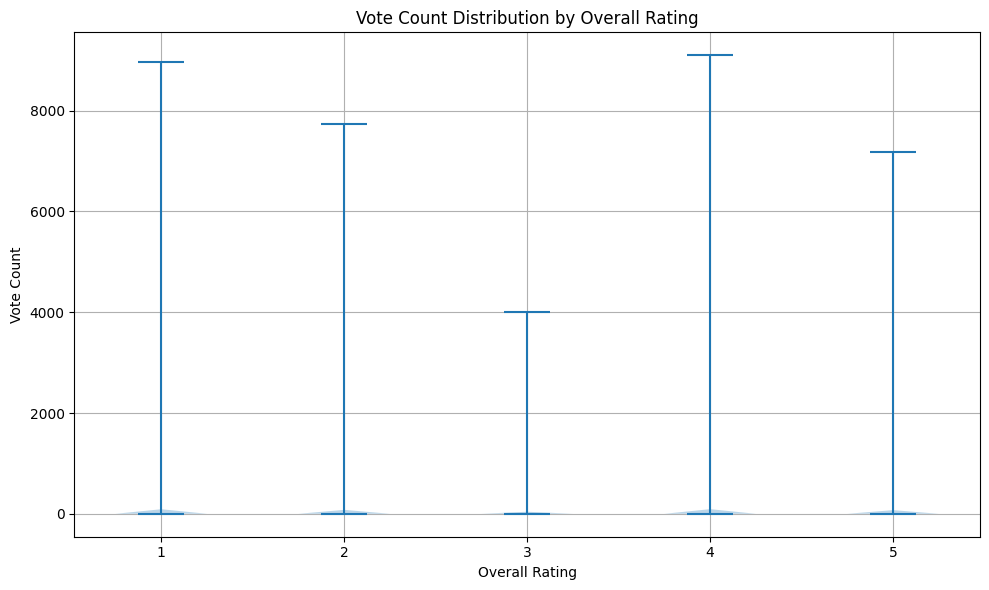

In [217]:
# Violin plot
plt.figure(figsize=(10, 6))
plt.violinplot([df_review_merged.loc[df_review_merged['overall'] == i, 'vote'] for i in range(1, 6)], positions=[1, 2, 3, 4, 5])
plt.title('Vote Count Distribution by Overall Rating')
plt.xlabel('Overall Rating')
plt.ylabel('Vote Count')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.tight_layout()

plt.show()


In [161]:
df_review_merged['image'].value_counts()

image
False    20224629
True       341735
Name: count, dtype: int64

In [86]:
df_image_true = df_review_merged[df_review_merged["image"] == True]
df_image_true.shape

(341735, 10)

In [87]:
df_image_true['vote'] = df_image_true['vote'].str.replace(',', '').astype(float)
df_image_true.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341735 entries, 291 to 20566329
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     341735 non-null  float64
 1   verified    341735 non-null  bool   
 2   reviewTime  341735 non-null  object 
 3   asin        341735 non-null  object 
 4   reviewText  341735 non-null  object 
 5   vote        103600 non-null  float64
 6   image       341735 non-null  bool   
 7   price       217909 non-null  float64
 8   main_cat    340305 non-null  object 
 9   Year        341735 non-null  int64  
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 24.1+ MB


C:\Users\rzp98\AppData\Local\Temp\ipykernel_5760\1599099460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_image_true['vote'] = df_image_true['vote'].str.replace(',', '').astype(float)


In [88]:
df_image_true['vote'].isna().sum()

238135

In [89]:
df_image_true = df_image_true.dropna(subset=['vote'])

In [90]:
df_image_true['vote'].value_counts()

vote
2.0       19119
3.0       13387
4.0        9744
5.0        7475
6.0        5909
          ...  
544.0         1
731.0         1
493.0         1
392.0         1
1542.0        1
Name: count, Length: 749, dtype: int64

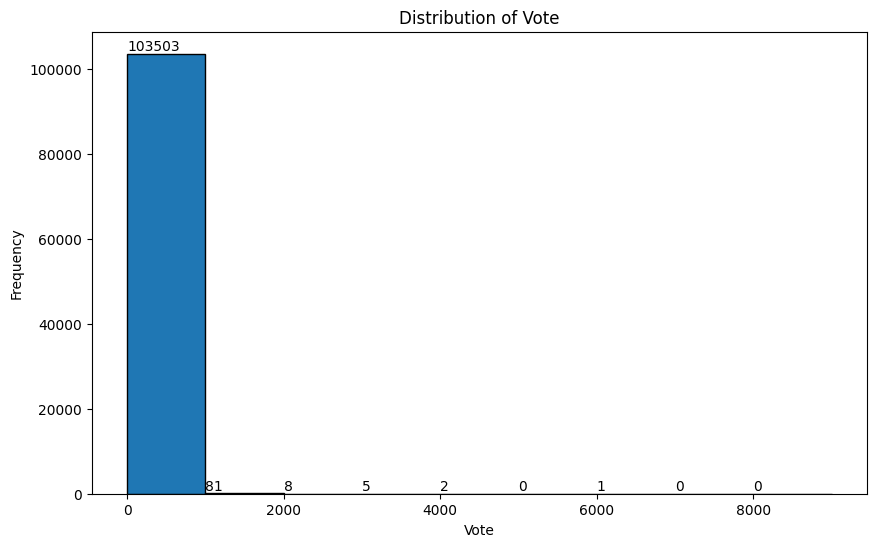

In [159]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df_image_true['vote'],bins=range(1, 10000, 1000), edgecolor='black')

for count, bin in zip(counts, bins):
    plt.text(bin, count, str(int(count)), rotation=0, va='bottom')

# Set the labels and title
plt.xlabel('Vote')
plt.ylabel('Frequency')
plt.title('Distribution of Vote')

# Show the plot
plt.show()

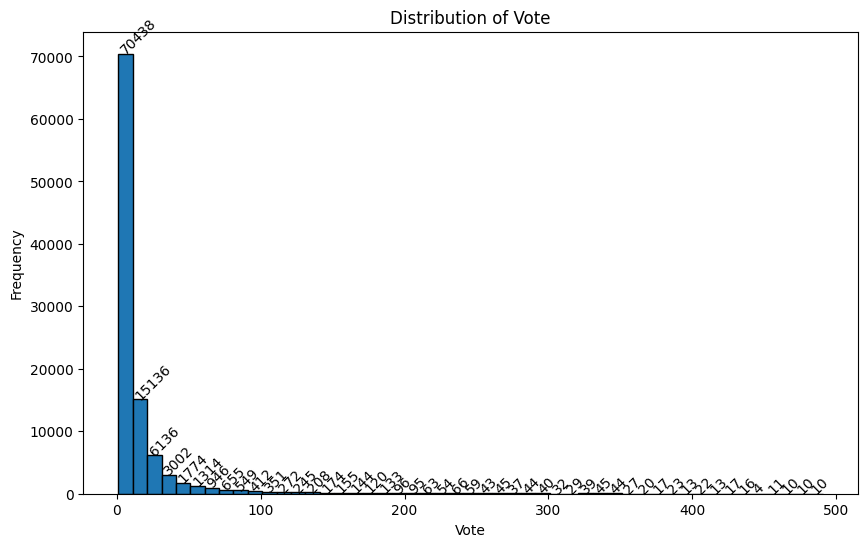

In [143]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df_image_true['vote'],bins=range(1, 500, 10), edgecolor='black')

for count, bin in zip(counts, bins):
    plt.text(bin, count, str(int(count)), rotation=45)

# Set the labels and title
plt.xlabel('Vote')
plt.ylabel('Frequency')
plt.title('Distribution of Vote')

# Show the plot
plt.show()

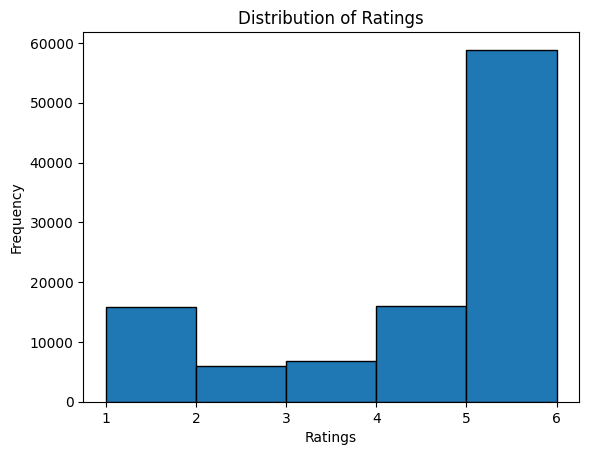

In [117]:
plt.hist(df_image_true['overall'], bins=range(1, 7), edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

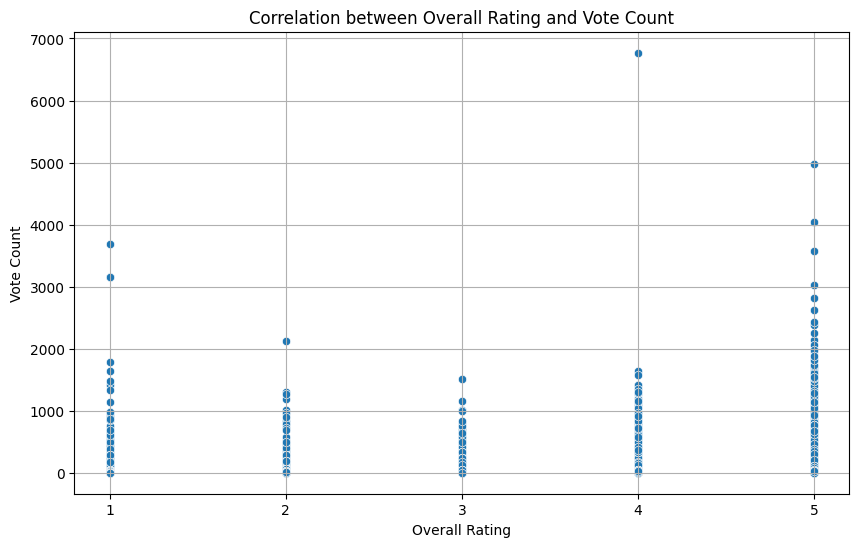

0.01474654730582192

In [98]:
correlation = df_image_true['overall'].corr(df_image_true['vote'])

# Visualize the correlation
plt.figure(figsize=(10, 6))
plt.xticks([1, 2, 3, 4, 5])
sns.scatterplot(x='overall', y='vote', data=df_image_true)
plt.title('Correlation between Overall Rating and Vote Count')
plt.xlabel('Overall Rating')
plt.ylabel('Vote Count')
plt.grid(True)
plt.show()

correlation

In [103]:
m, b = np.polyfit(df_image_true['overall'], df_image_true['vote'], 1)
m

0.7500423132425983

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


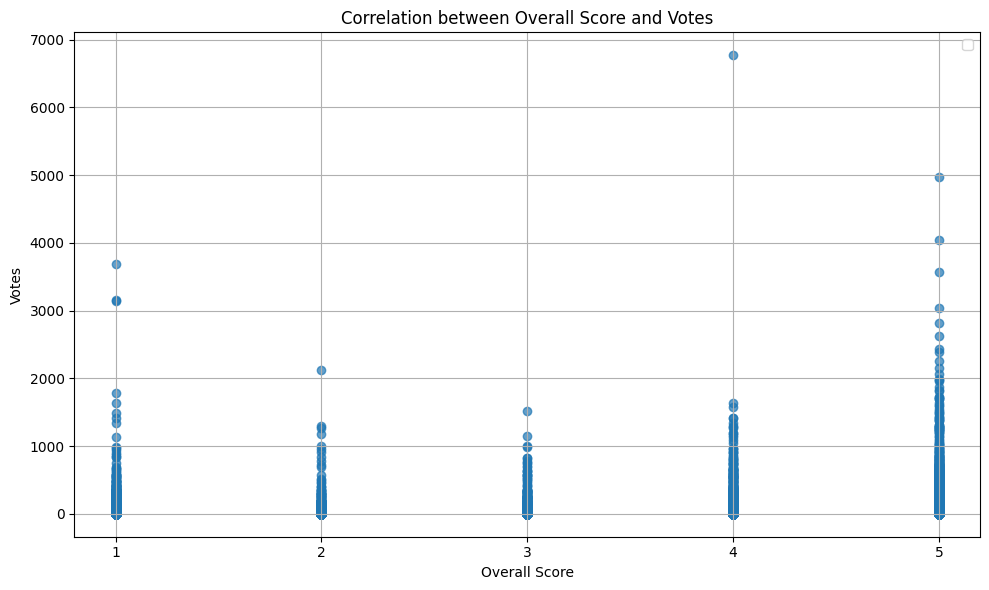

In [108]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.xticks([1, 2, 3, 4, 5])
plt.scatter(df_image_true['overall'], df_image_true['vote'], alpha=0.7)

plt.title('Correlation between Overall Score and Votes')
plt.xlabel('Overall Score')
plt.ylabel('Votes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [111]:
df_image_true['vote'].value_counts()

vote
2.0       19119
3.0       13387
4.0        9744
5.0        7475
6.0        5909
          ...  
544.0         1
731.0         1
493.0         1
392.0         1
1542.0        1
Name: count, Length: 749, dtype: int64

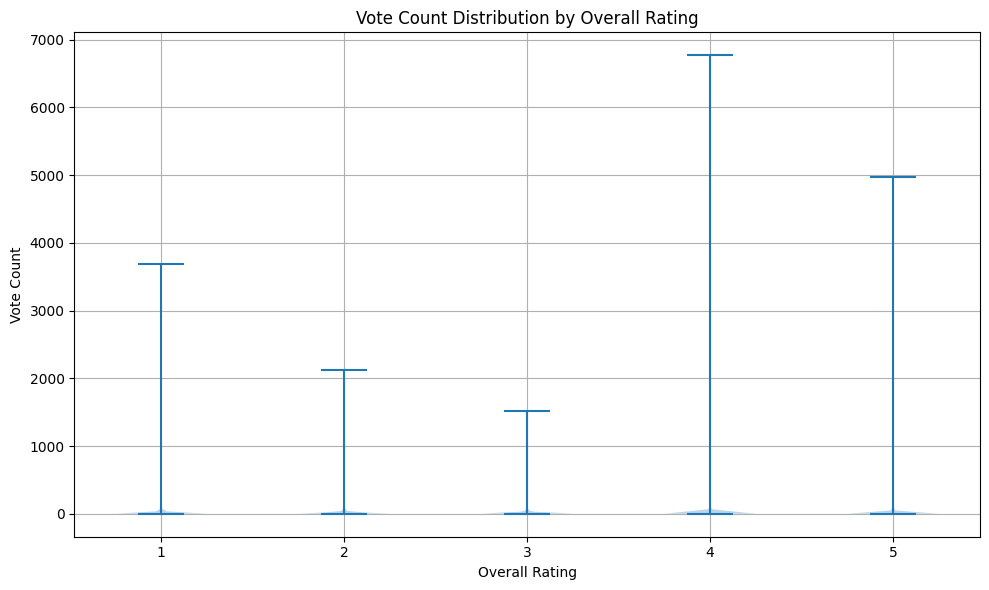

In [113]:
# Violin plot
plt.figure(figsize=(10, 6))
plt.violinplot([df_image_true.loc[df_image_true['overall'] == i, 'vote'] for i in range(1, 6)], positions=[1, 2, 3, 4, 5])
plt.title('Vote Count Distribution by Overall Rating')
plt.xlabel('Overall Rating')
plt.ylabel('Vote Count')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.tight_layout()

plt.show()


using with and without image

In [163]:
df_review_merged['image']

0           False
1           False
2           False
3           False
4           False
            ...  
20566359    False
20566360    False
20566361    False
20566362    False
20566363    False
Name: image, Length: 20566364, dtype: bool

In [188]:
df_image_false = df_review_merged[df_review_merged["image"] == False]
df_image_false.shape
df_image_false.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20224629 entries, 0 to 20566363
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   verified    bool   
 2   reviewTime  object 
 3   asin        object 
 4   reviewText  object 
 5   vote        object 
 6   image       bool   
 7   price       float64
 8   main_cat    object 
 9   Year        int64  
dtypes: bool(2), float64(2), int64(1), object(5)
memory usage: 1.4+ GB


In [195]:
df_image_false['vote'].isna().sum()

0

In [201]:
df_image_false = df_image_false.dropna(subset=['vote'])
df_image_false['vote'].info()

<class 'pandas.core.series.Series'>
Index: 1720155 entries, 2 to 17235965
Series name: vote
Non-Null Count    Dtype 
--------------    ----- 
1720155 non-null  object
dtypes: object(1)
memory usage: 26.2+ MB


In [206]:
df_image_false['vote'].value_counts()

vote
2       590282
3       301192
4       177375
5       119224
6        82677
         ...  
1302         1
1099         1
979          1
508          1
1524         1
Name: count, Length: 1401, dtype: int64

In [207]:
df_image_false['vote'] = df_image_false['vote'].str.replace(',', '').astype(float)
df_image_false.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1720155 entries, 2 to 17235965
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   verified    bool   
 2   reviewTime  object 
 3   asin        object 
 4   reviewText  object 
 5   vote        float64
 6   image       bool   
 7   price       float64
 8   main_cat    object 
 9   Year        int64  
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 121.4+ MB


In [208]:
df_image_false['vote'].describe()

count    1.720155e+06
mean     9.331640e+00
std      4.473766e+01
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      7.000000e+00
max      9.096000e+03
Name: vote, dtype: float64

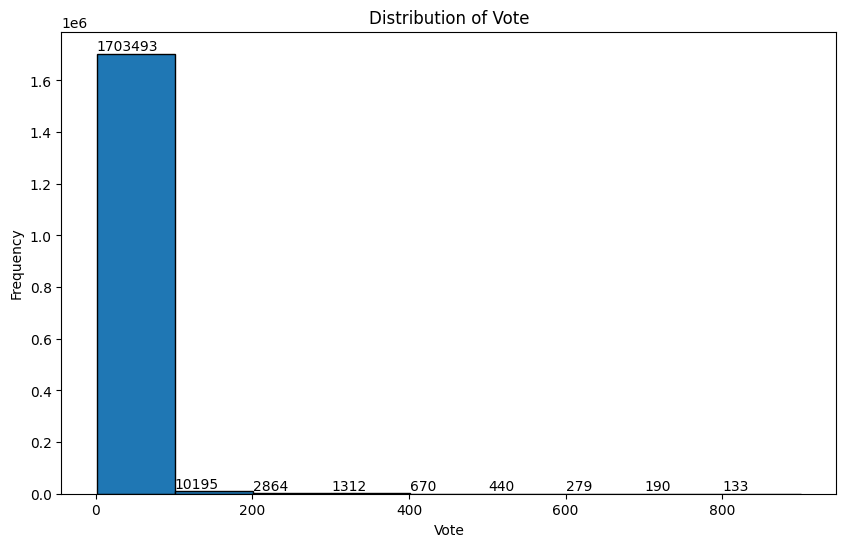

In [209]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df_image_false['vote'],bins=range(1, 1000, 100), edgecolor='black')

for count, bin in zip(counts, bins):
    plt.text(bin, count, str(int(count)), rotation=0, va='bottom')

# Set the labels and title
plt.xlabel('Vote')
plt.ylabel('Frequency')
plt.title('Distribution of Vote')

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


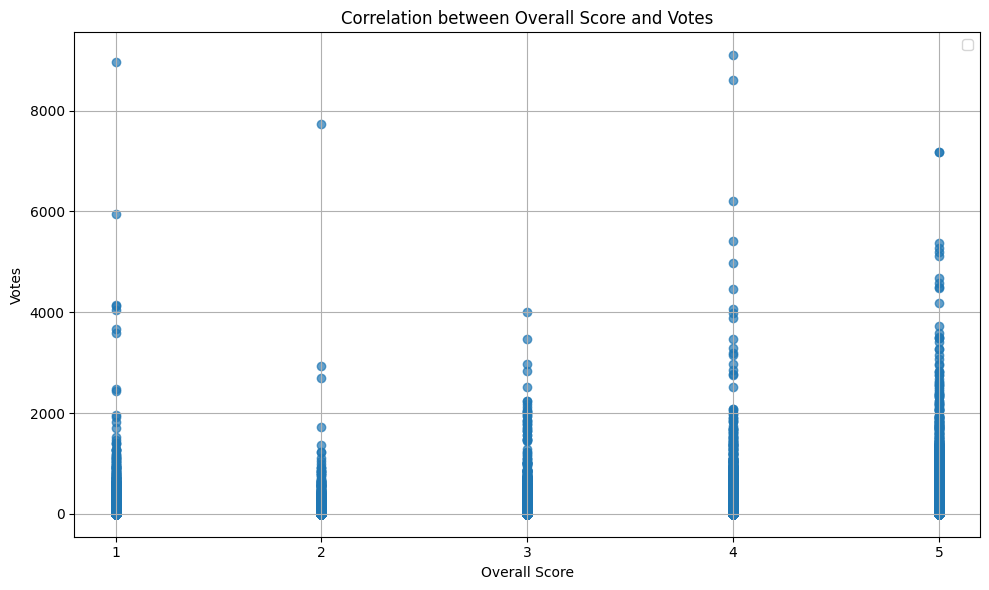

In [210]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.xticks([1, 2, 3, 4, 5])
plt.scatter(df_image_false['overall'], df_image_false['vote'], alpha=0.7)

plt.title('Correlation between Overall Score and Votes')
plt.xlabel('Overall Score')
plt.ylabel('Votes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()